# Dynamic Time Warping and Audio-Score Alignment 
### George Tzanetakis, University of Victoria 

In this notebook we explore how to perform sequence alignent using dynamic programming. When the sequences considered correspond to time sequence of feature vectors this is called Dynamic Time Warping (DTW). It allows us to find correspondances between the two time sequences which enables applications such as cover song identification and audio-score alignment. This can be viewed as an extension of the computation of edit distance between strings using dynamic programming that we have already described. 


In [3]:
import scipy.io.wavfile as wav
import numpy as np
import IPython.display as ipd




def load_wav(fname): 
    srate, audio = wav.read(fname)
    audio = audio.astype(np.float32) / 32767.0 
    audio = (0.9 / np.max(audio)) * audio
    # convert to mono 
    if (len(audio.shape) == 2):
        audio = (audio[:, 0] + audio[:, 1]) / 2
    return (audio,srate) 


lamer1,srate = load_wav('lamer1.wav')
lamer2,srate = load_wav('lamer2.wav')
lamer3,srate = load_wav('lamer3.wav')



In [6]:
ipd.Audio(lamer1[15*44100:30*44100],rate=srate)

In [8]:
ipd.Audio(lamer2[15*44100:30*44100],rate=srate)

In [10]:
ipd.Audio(lamer3[15*44100:30*44100],rate=srate)

In [11]:
def rms_track(signal, hopSize, winSize): 
    offsets = np.arange(0, len(signal), hopSize)
    amp_track = np.zeros(len(offsets))
    
    for (m,o) in enumerate(offsets): 
        frame = signal[o:o+winSize] 
        amp_track[m] = np.sqrt(np.mean(np.square(frame)))         
    return amp_track


hopSize = 8192
winSize = 8192

# compute the rms tracks
lm1_track = rms_track(lamer1, hopSize, winSize)
lm2_track = rms_track(lamer2, hopSize, winSize)
lm3_track = rms_track(lamer3, hopSize, winSize)


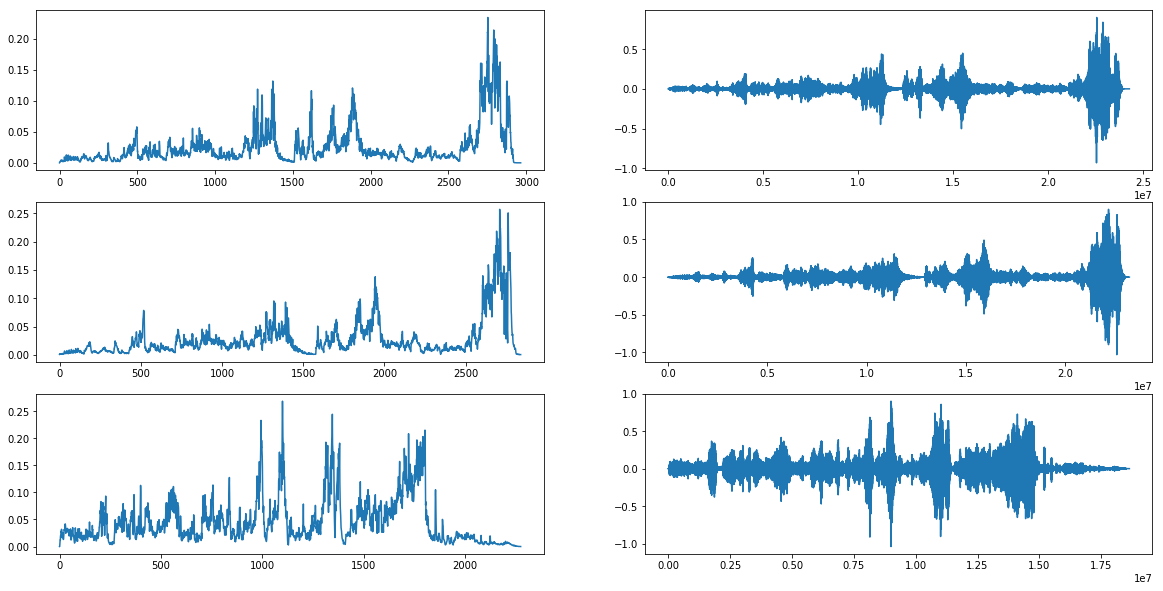

In [12]:
%matplotlib inline 
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10)) 
plt.subplot(321)
plt.plot(lm1_track)
plt.subplot(322)
plt.plot(lamer1)
plt.subplot(323)
plt.plot(lm2_track)
plt.subplot(324)
plt.plot(lamer2)
plt.subplot(325)
plt.plot(lm3_track)
plt.subplot(326)
plt.plot(lamer3)
plt.show()


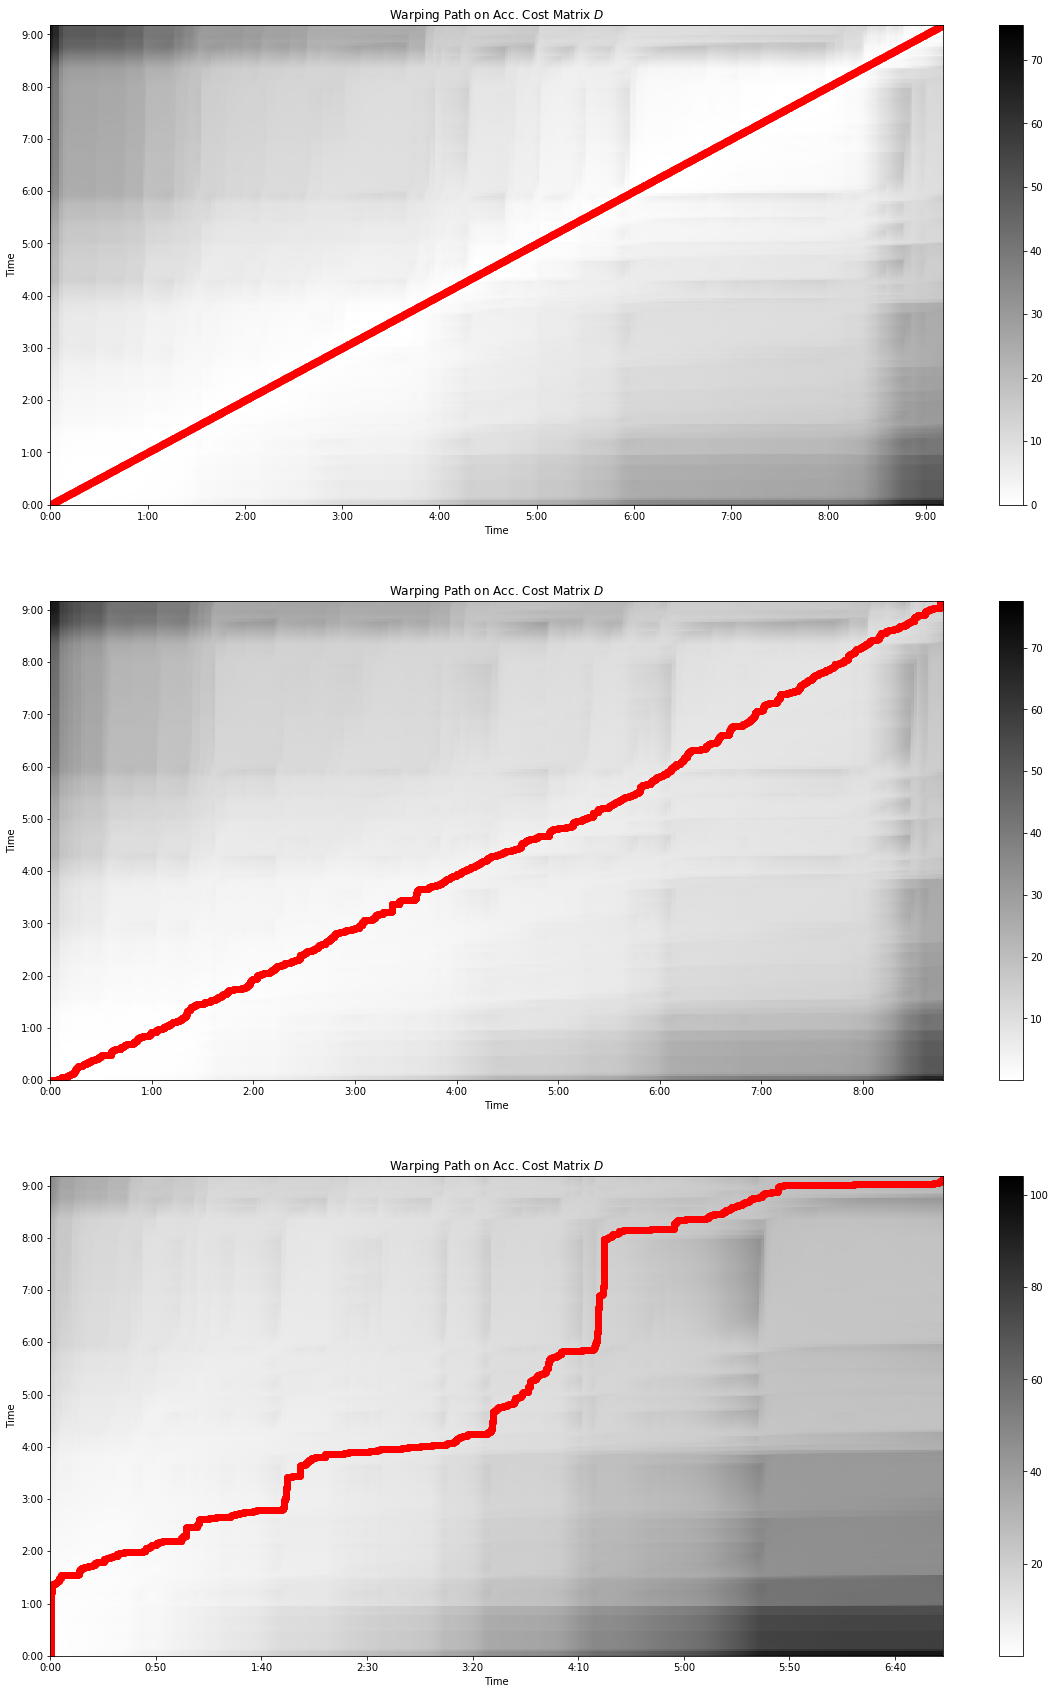

In [13]:
import librosa.core
import librosa.display


def plot_dtw(x,y,srate,ax): 
    hop_size = 8192
    D, wp = librosa.sequence.dtw(X=x, Y=y, metric='euclidean')
    wp_s = np.asarray(wp) * hop_size / srate

    librosa.display.specshow(D, x_axis='time', y_axis='time',
                             cmap='gray_r', hop_length=hop_size,sr=srate)
    imax = ax.imshow(D, cmap=plt.get_cmap('gray_r'),
                     origin='lower', interpolation='nearest', aspect='auto')
    ax.plot(wp_s[:, 1], wp_s[:, 0], marker='o', color='r')
    plt.title('Warping Path on Acc. Cost Matrix $D$')
    plt.colorbar()
    return plt, wp 


lm1_track = lm1_track.reshape(1,-1)
lm2_track = lm2_track.reshape(1,-1)
lm3_track = lm3_track.reshape(1,-1)


fig = plt.figure(figsize=(20, 30))
ax = fig.add_subplot(311)
plot1,wp1 = plot_dtw(lm1_track, lm1_track, srate, ax)
ax = fig.add_subplot(312)
plot2,wp2 = plot_dtw(lm1_track, lm2_track, srate, ax)
ax = fig.add_subplot(313)
plot3,wp3 = plot_dtw(lm1_track, lm3_track, srate, ax)


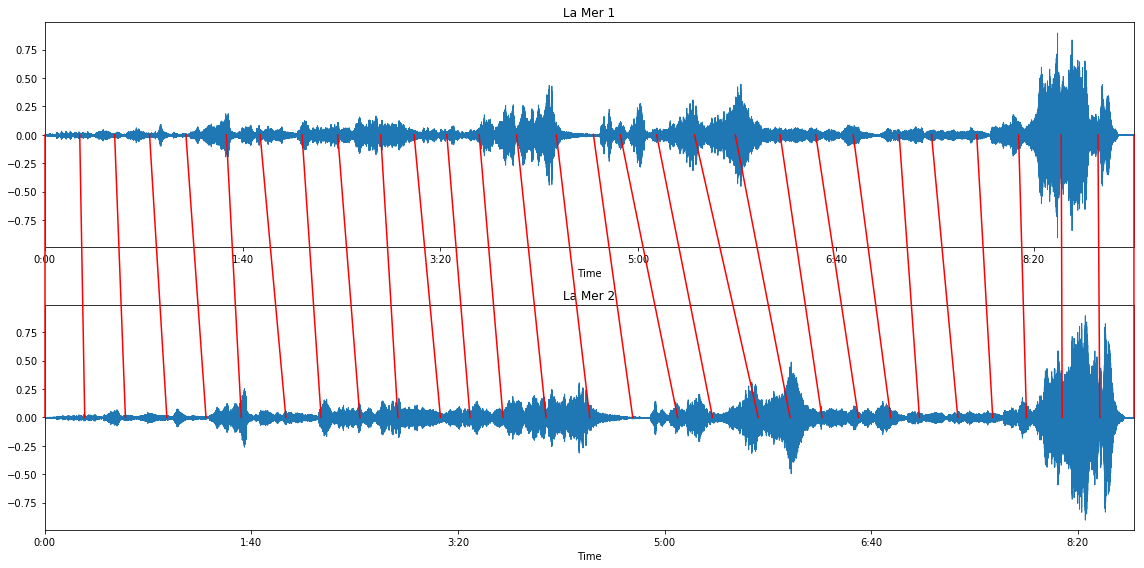

In [14]:

import matplotlib.lines 

wp = wp2
fig = plt.figure(figsize=(16, 8))
hop_size = 8192

# Plot x_1
plt.subplot(2, 1, 1)
librosa.display.waveplot(lamer1, sr=srate)
plt.title('La Mer 1')
ax1 = plt.gca()

# Plot x_2
plt.subplot(2, 1, 2)
librosa.display.waveplot(lamer2, sr=srate)
plt.title('La Mer 2')
ax2 = plt.gca()

plt.tight_layout()

trans_figure = fig.transFigure.inverted()
lines = []
arrows = 30
points_idx = np.int16(np.round(np.linspace(0, wp.shape[0] - 1, arrows)))

for tp1, tp2 in wp[points_idx] * hop_size / srate:
    # get position on axis for a given index-pair
    coord1 = trans_figure.transform(ax1.transData.transform([tp1, 0]))
    coord2 = trans_figure.transform(ax2.transData.transform([tp2, 0]))

    # draw a line
    line = matplotlib.lines.Line2D((coord1[0], coord2[0]),
                        (coord1[1], coord2[1]),
                        transform=fig.transFigure,
                        color='r')
    lines.append(line)

fig.lines = lines
plt.tight_layout()

An interesting application of dynamic time warping (DTW) is audio-score alignment. In this application we are interested in associating each location in a music score to a corresponding location in an audio recording. 
This can enable intelligent audio editing, for example clicking on a particular measure in an orchestral score can take the user directly to the corresponding instance in time of an audio recording of the piece being played. 
In the following example, we explore this idea using two versions of the same piece of music: the first one is an actual audio recording and the second one is an audio version creating from a MIDI symbolic representation. Each 
recording has a different duration and a tempo but using DTW we are able to align them. 

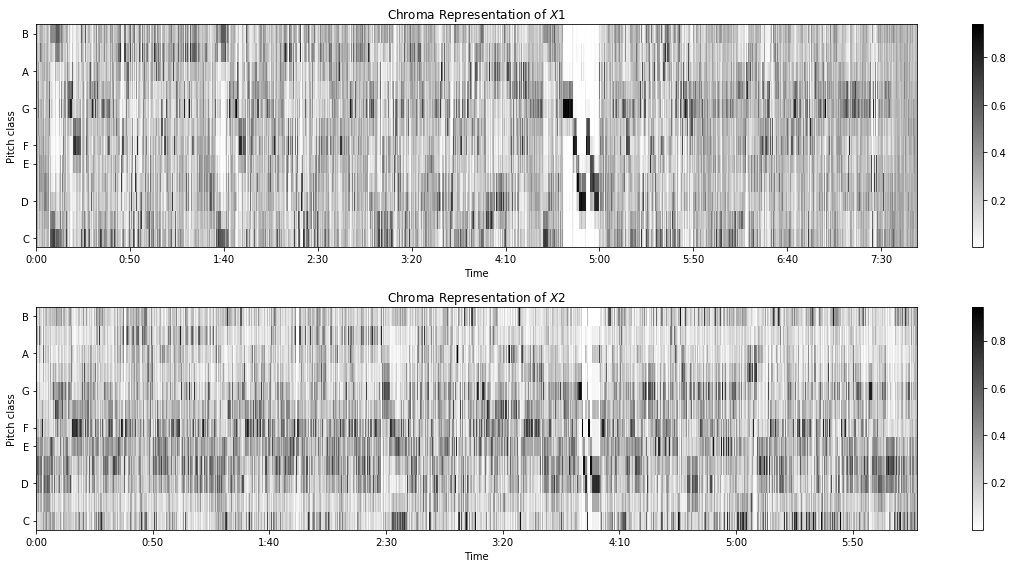

In [31]:
n_fft = 1024
hop_size = 4096


x1, srate = load_wav('live-beethoven_symphony5_mv1.wav')
x2, srate = load_wav('midi-beethoven_symphony5_mv1.wav')


x_1_chroma = librosa.feature.chroma_stft(y=x1, sr=srate, tuning=0, norm=2,
                                         hop_length=hop_size, n_fft=n_fft)
x_2_chroma = librosa.feature.chroma_stft(y=x2, sr=srate, tuning=0, norm=2,
                                         hop_length=hop_size, n_fft=n_fft)

plt.figure(figsize=(16, 8))
plt.subplot(2, 1, 1)
plt.title('Chroma Representation of $X1$')
librosa.display.specshow(x_1_chroma, sr=srate, x_axis='time',
                         y_axis='chroma', cmap='gray_r', hop_length=hop_size)
plt.colorbar()
plt.subplot(2, 1, 2)
plt.title('Chroma Representation of $X2$')
librosa.display.specshow(x_2_chroma, x_axis='time',sr=srate,
                         y_axis='chroma', cmap='gray_r', hop_length=hop_size)
plt.colorbar()
plt.tight_layout()

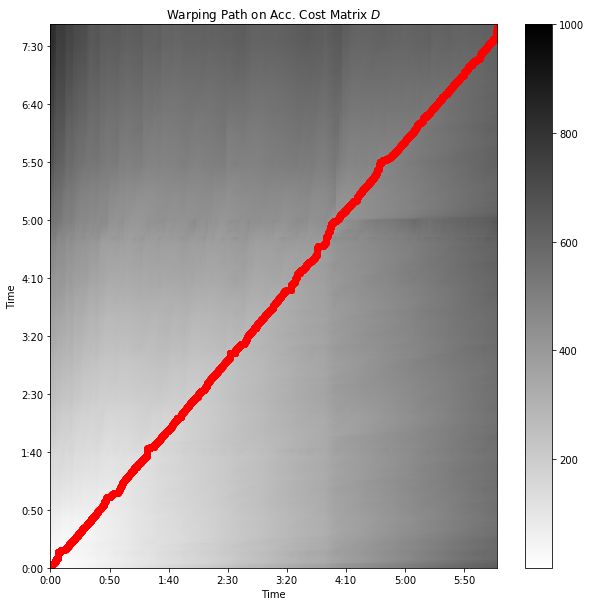

In [32]:
D, wp = librosa.sequence.dtw(X=x_1_chroma, Y=x_2_chroma, metric='cosine')
wp_s = np.asarray(wp) * hop_size / srate

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

librosa.display.specshow(D, sr=srate, x_axis='time', y_axis='time',
                         cmap='gray_r', hop_length=hop_size)
imax = ax.imshow(D, cmap=plt.get_cmap('gray_r'),
                 origin='lower', interpolation='nearest', aspect='auto')
ax.plot(wp_s[:, 1], wp_s[:, 0], marker='o', color='r')
plt.title('Warping Path on Acc. Cost Matrix $D$')
plt.colorbar()
plt.show()

If you look at the warping path you will notice that there a change in slope around minute 5 of the audio recording and around minute 4 of the MIDI recording. This corresponds to the a short Oboe solo that in the audio recording is played very expressively and slower but in the MIDI is just played using fixed tempo. These two short solos are also visible on the chromagrams above. Let's listen to these two short Oboe solos. 

In [17]:
o1, srate = load_wav('live-beethoven_symphony5_mv1_oboe.wav')
o2, srate = load_wav('midi-beethoven_symphony5_mv1_oboe.wav')


In [18]:
ipd.Audio(o1,rate=srate)


In [19]:
ipd.Audio(o2,rate=srate)